<a href="https://colab.research.google.com/github/monicafar147/climate-change-tweet-classifier/blob/framework/climate_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Climate change belief analysis hosted on Kaggle**

This notebook was created to solve the Kaggle climate-change-belief-analysis challenge.

Climate change has been a trending topic ever since Al Gore received a Nobel Peace Prize for his campaign in 2007. The topic has become a controversial subject on twitter where some twitter users feel very strongly that climate change is not real and is part of a conspiracy theory.

Twitter user sentiments can be classified as either:

* -1 as Anti: The tweet does not believe in climate change
* 0 as Neutral: The tweet neither supports nor refutes the belief in climate change
* 1 as Pro: The tweet supports the belief of climate change
* 2 as News: The tweet links to factual news about climate change

In this notebook we will go through the steps our team took to deal with this challenge, we start with the EDA and preprocessing and have tried multiple models. We will describe the steps as we go along. Our aim is to build a final model that is able to classify tweets into four categories in regards to climate change: positive for climate change, against climate change, Neutral or Factual

# Problem Statement

How people perceive climate change and whether or not they believe it is a real threat, there are many companies that are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable.

This classification model would add to their market research efforts in gauging how their product/service may be received.

# Imports

## Importing the modules

In [1]:
# general
import numpy as np 
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# text preprocessing
import re
from string import punctuation
import nltk
nltk.download(['stopwords','punkt'])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import Word
from wordcloud import WordCloud, STOPWORDS

# models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

#model analysis
from sklearn.metrics import classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Importing the data

Importing the data from Our repo this data contains the training and testing datasets, in the form of a csv file, so we will import the files and convert to a dataframe

In [2]:
# importing the DataSets
train = pd.read_csv("https://raw.githubusercontent.com/monicafar147/classification-predict-streamlit-template/master/climate-change-belief-analysis/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/monicafar147/classification-predict-streamlit-template/master/climate-change-belief-analysis/test.csv")

In [5]:
print("Train\n")
display(train.head(5))
print("\nTest")
display(test.head(5))
print("\n(Datasets were imported correctly)")

Train



,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954



Test


,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928



(Datasets were imported correctly)


# Exploratory Data Analysis (EDA)

The first step we must take after importing the data is to explore the datasets and try to understand the data, and see what may lie behind the obvious

For our firt step in EDA we will see if there are any repeats or Null values in the dataset


In [6]:
# Checking that there is no repeats in the Data
unique = [row for row in train['tweetid'].unique()]
print("Number of unique values")
print(train['tweetid'].nunique())
print("\nTotal number of values")
print(len(train['tweetid']))
print("\nNumber of null values:\n" + str(train.isnull().sum()))

print('\nWe can see the data does not contain any Null or repeated rows')

Number of unique values
15819

Total number of values
15819

Number of null values:
sentiment    0
message      0
tweetid      0
dtype: int64

We can see the data does not contain any Null or repeated rows


Now we will explore the data more in depth.
We want to classify the tweets based on the sentiment and we need to see what the data holds in terms of the distribution of the sentiments we will do this by creating a dataframe to see the exact values and by creating a graph for a more visual representation.

In [7]:
sum_df = train[['sentiment', 'message',]].groupby('sentiment').count()
sum_df

,message
sentiment,
-1,1296
0,2353
1,8530
2,3640


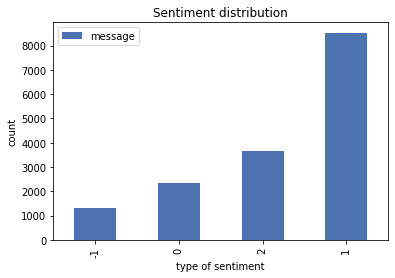

In [ ]:
sum_df.sort_values('message', ascending=True).plot(kind='bar')
plt.title('Sentiment distribution')
plt.ylabel('count')
plt.xlabel('type of sentiment')
plt.show()

From this we see our data is highly uneven as the dominant sentiment is 1. 

This means it may be benifical to re-scale the data such as up-sampling or down-sampling we will keep this in mind as we move on.

The data also could be unevenly distributed with the length of the tweets themselves it would be helpful to plot this on a graph so we can see the distribution clearly.

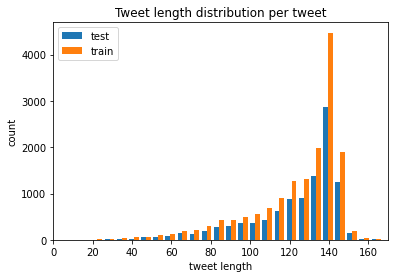

In [8]:
# Explore the word count and tweet lengths
train['length'] = train['message'].astype(str).apply(len)
train['word_count'] = train['message'].apply(lambda x: len(str(x).split()))
test['length'] = test['message'].astype(str).apply(len)
test['word_count'] = test['message'].apply(lambda x: len(str(x).split()))

# Creating the plot
plt.hist([test['length'], train['length']], bins=100, label=['test', 'train'])
plt.title('Tweet length distribution per tweet')
plt.xlabel('tweet length')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,170])
plt.show()

The train data seems to have longer words in general, this could be due to the training data being longer and having a bigger variety of tweets therefore more likely to have longer tweets

Now we do something very similar but with the word count of the tweets 

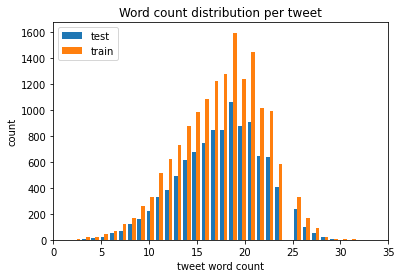

In [9]:
plt.hist([test['word_count'], train['word_count']], bins=100, label=['test', 'train'])
plt.title('Word count distribution per tweet')
plt.xlabel('tweet word count')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,35])
plt.show()

Which words are most commonly found in each sentiment?

To answer that question we tokenize each tweet and then group each tweet by the sentiment that was assigned to it in the training data and form a dictionary to show the bag of words associated with each sentiment.

In [10]:
from nltk.tokenize import TweetTokenizer
tokeniser = TweetTokenizer()
train['tokens'] = train['message'].apply(tokeniser.tokenize)

In [11]:
def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary 
        with each word as a key, and the value represents the number of 
        times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

In [12]:
sentiment_labels = list(set(train['sentiment'].values))
sentiment = {}
for sent in sentiment_labels:
    df = train.groupby('sentiment')
    sentiment[sent] = {}
    for row in df.get_group(sent)['tokens']:
        sentiment[sent] = bag_of_words_count(row, sentiment[sent]) 

In [13]:
anti_tweets = {key: value for key, value in sorted(sentiment[-1].items(), key=lambda item: item[1], reverse=True)}
neutral_tweets = {key: value for key, value in sorted(sentiment[0].items(), key=lambda item: item[1], reverse=True)}
pro_tweets = {key: value for key, value in sorted(sentiment[1].items(), key=lambda item: item[1], reverse=True)}
news_tweets = {key: value for key, value in sorted(sentiment[2].items(), key=lambda item: item[1], reverse=True)}

In the dictionary there are random characters that take up the space. 

Create a list to remove those characters.

In [14]:
random_characters = ['â','¢','‚','¬','Â','¦','’',"It's",'Ã','..','Å']

make lists of the keys and values for each sentiment with the following conditions:
*   Removes random characters
*   Removes stopwords
*   Removes punctuation



In [15]:
# anti
anti_keys = [key for key in anti_tweets.keys() if key not in set(random_characters+stopwords.words('english') + list(punctuation))]
anti_values = [value[1] for value in anti_tweets.items() if value[0] not in set(random_characters+stopwords.words('english') + list(punctuation))]

# neutral
neutral_keys = [key for key in neutral_tweets.keys() if key not in set(random_characters+stopwords.words('english') + list(punctuation))]
neutral_values = [value[1] for value in neutral_tweets.items() if value[0] not in set(random_characters+stopwords.words('english') + list(punctuation))]

# pro
pro_keys = [key for key in pro_tweets.keys() if key not in set(random_characters+stopwords.words('english') + list(punctuation))]
pro_values = [value[1] for value in pro_tweets.items() if value[0] not in set(random_characters+stopwords.words('english') + list(punctuation))]

# news
news_keys = [key for key in news_tweets.keys() if key not in set(random_characters+stopwords.words('english') + list(punctuation))]
news_values = [value[1] for value in news_tweets.items() if value[0] not in set(random_characters+stopwords.words('english') + list(punctuation))]

**Create a barplot to show the most common words in anti tweets**

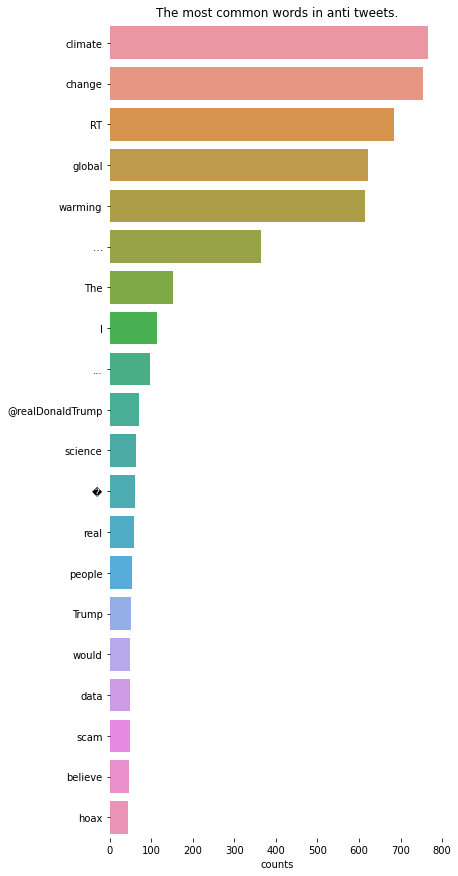

In [ ]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(anti_values[0:20],anti_keys[0:20])
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('The most common words in anti tweets.')
sns.despine(left=True, bottom=True)

**Create a barplot to show the most common words in neutral tweets**

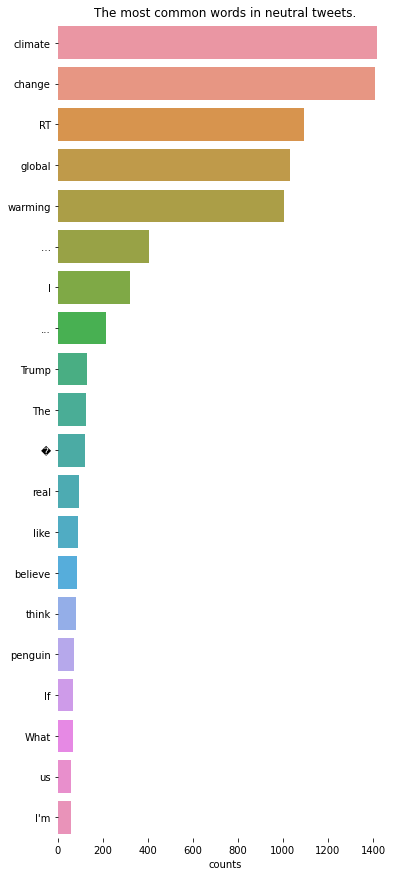

In [ ]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(neutral_values[0:20],neutral_keys[0:20])
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('The most common words in neutral tweets.')
sns.despine(left=True, bottom=True)

**Create a barplot to show the most common words in pro tweets**

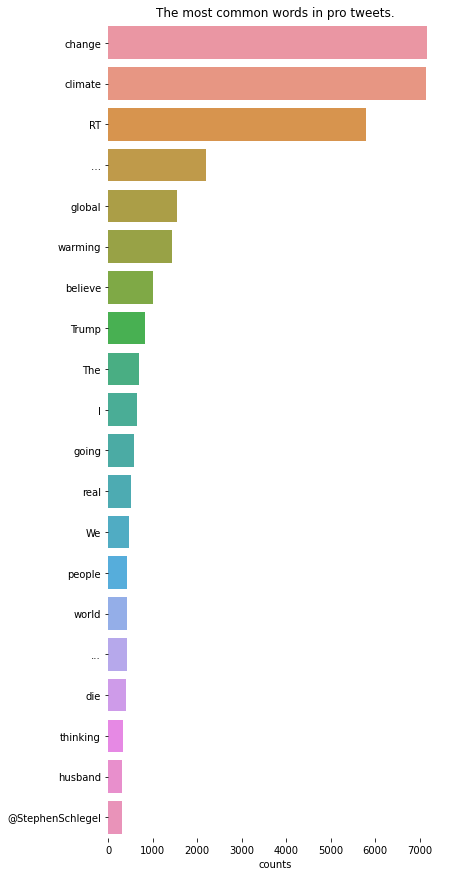

In [ ]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(pro_values[0:20],pro_keys[0:20])
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('The most common words in pro tweets.')
sns.despine(left=True, bottom=True)

**Create a barplot to show the most common words in news tweets**

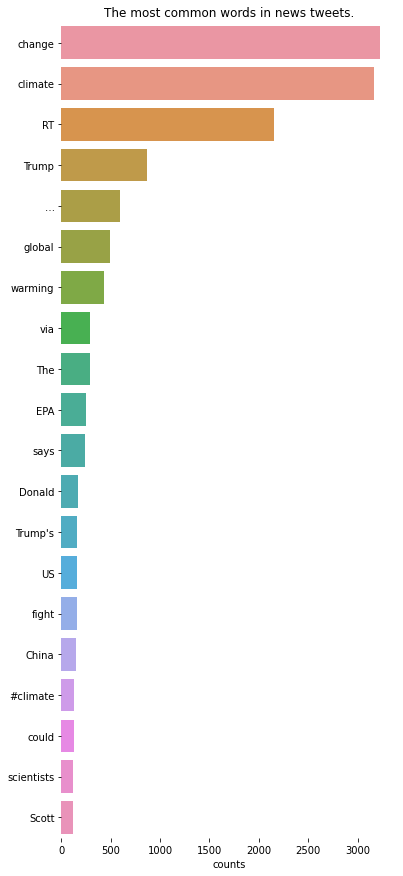

In [ ]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(news_values[0:20],news_keys[0:20])
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('The most common words in news tweets.')
sns.despine(left=True, bottom=True)

we will now create word clouds based on the two datasets to get insights into which words are the most common and hopefully being able to better understand what the dataset contains and how maybe given insights into how the models work once we develop them

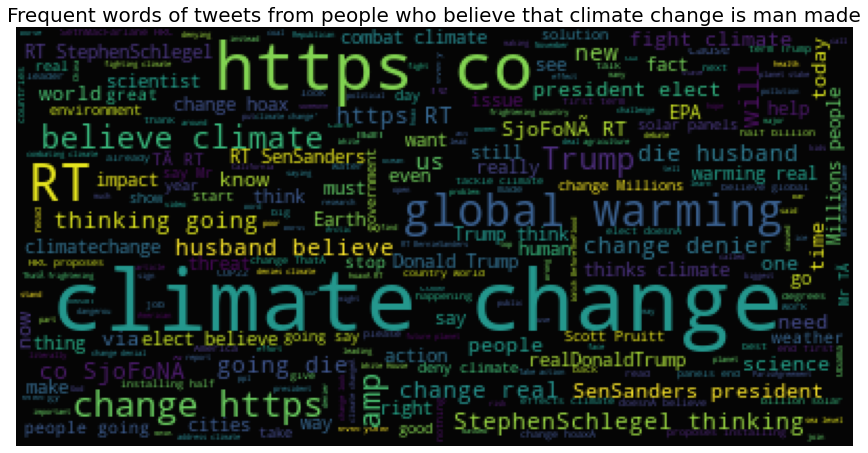

In [ ]:
# Creating the word cloud
rnd_comments = train[train['sentiment']==1].sample(n=2000)['message'].values
wc = WordCloud(background_color='black', max_words=2000, stopwords=STOPWORDS)
wc.generate(''.join(rnd_comments))

# Plotting the word cloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title('Frequent words of tweets from people who believe that climate change is man made', fontsize=20)
plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)
plt.show()

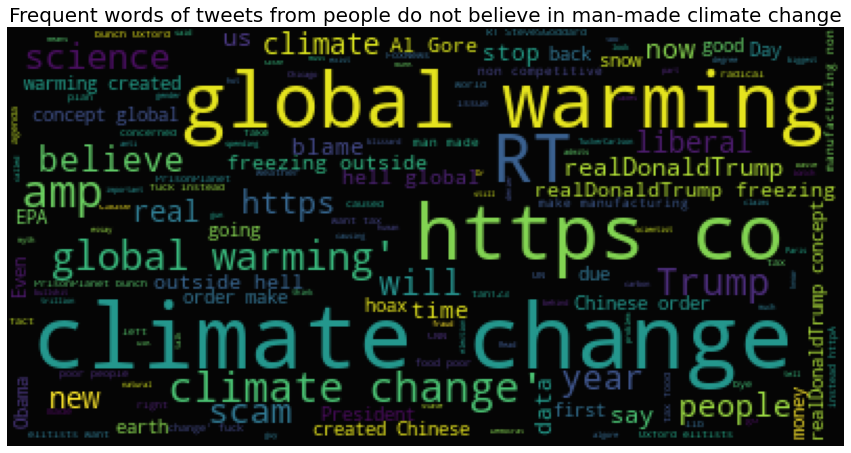

In [ ]:
# Creating the word cloud
rnd_comment = train[train['sentiment']==-1].sample(n=200)['message'].values
wc = WordCloud(background_color='black', max_words=2000, stopwords=STOPWORDS)
wc.generate(''.join(rnd_comment))

#plotting the word cloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title('Frequent words of tweets from people do not believe in man-made climate change', fontsize=20)
plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)
plt.show()

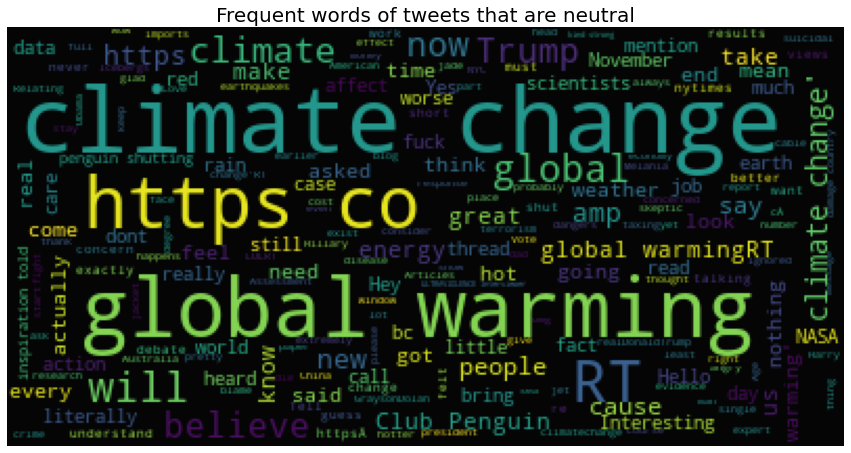

In [ ]:
# Creating the word cloud
rnd_comment = train[train['sentiment']==0].sample(n=200)['message'].values
wc = WordCloud(background_color='black', max_words=2000, stopwords=STOPWORDS)
wc.generate(''.join(rnd_comment))

#plotting the word cloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title('Frequent words of tweets that are neutral', fontsize=20)
plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)
plt.show()

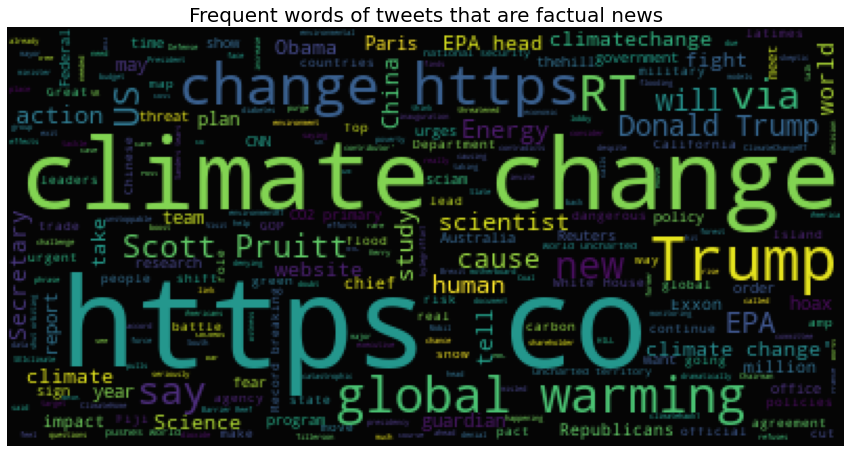

In [ ]:
# Creating the word cloud
rnd_comment = train[train['sentiment']==2].sample(n=200)['message'].values
wc = WordCloud(background_color='black', max_words=2000, stopwords=STOPWORDS)
wc.generate(''.join(rnd_comment))

#plotting the word cloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title('Frequent words of tweets that are factual news', fontsize=20)
plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)
plt.show()

These word clouds can tell us various things about the data and it is good to see what words come up the most.

For anti tweets:
*   The word **science** pops up often
*   **Steves Goddard** is referenced often
*   Politicians referenced include **Al Gore**, **Obama** and **Donald Trump**

For pro tweets:
*   **Steven Schlegel** is referenced often.
*   The word **Sjofona**  pops up often.
*   The word **husband** pops up for some reason.
*   Politicians referenced include **Sen Sanders** and **Donald Trump**

For neutral tweets:
*   the word **journalist** pops up.
*   Places referrenced are **America** and **Paris**.
*   **Chelsea Clinton** is referrenced.
*   Politicians referenced include **Donald Trump**
*   Celebrities referenced incluse **Leonardo Dicaprio**
*   Strong emotional words include **please**, **action**, **fuck** and **responsible**

For news tweets:
*   The word **EPA** pops up.
*   News outlets referenced include **CNN**, **Guardian**, **Time**.
*   **Scott Prutt** is mentioned
*   THe word **independent study** pops up.
*   the **white house** and **Trump** is mentioned.
*   Countries that pop up include **US** and **China**


The data also could be unevenly distributed with the length of the tweets themselves it would be helpful to plot this on a graph so we can see the distribution clearly.

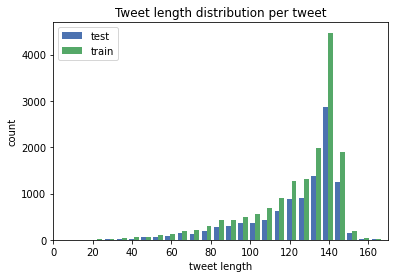

In [ ]:
# Explore the word count and tweet lengths
train['length'] = train['message'].astype(str).apply(len)
train['word_count'] = train['message'].apply(lambda x: len(str(x).split()))
test['length'] = test['message'].astype(str).apply(len)
test['word_count'] = test['message'].apply(lambda x: len(str(x).split()))

# Creating the plot
plt.hist([test['length'], train['length']], bins=100, label=['test', 'train'])
plt.title('Tweet length distribution per tweet')
plt.xlabel('tweet length')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,170])
plt.show()

The train data seems to have longer words in general, this could be due to the training data being longer and having a bigger variety of tweets therefore more likely to have longer tweets

Now we do something very similar but with the word count of the tweets 

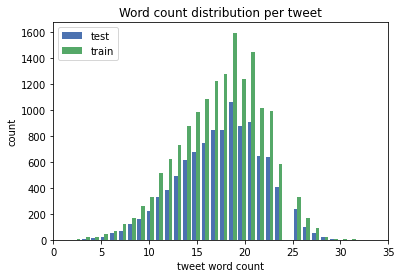

In [ ]:
plt.hist([test['word_count'], train['word_count']], bins=100, label=['test', 'train'])
plt.title('Word count distribution per tweet')
plt.xlabel('tweet word count')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,35])
plt.show()

next we will find out what hashtags are most frequently tweeted with the various sentiments.

In [ ]:
# Anti climate change hashtags
anti = train[train['sentiment']==-1]
a_tweets = anti['message']
series_a = a_tweets.str.extractall(r'(\#\w+)')[0].value_counts()

# Pro climate change hashtags
pro = train[train['sentiment']==1]
p_tweets = pro['message']
series_p = p_tweets.str.extractall(r'(\#\w+)')[0].value_counts()

# Neutral climate change hashtags
neutral = train[train['sentiment']==0]
neutral_tweets = neutral['message']
series_neutral = neutral_tweets.str.extractall(r'(\#\w+)')[0].value_counts()

# News climate change hashtags
news = train[train['sentiment']==2]
news_tweets = news['message']
series_news = news_tweets.str.extractall(r'(\#\w+)')[0].value_counts()

print("\033[1mAnti Climate change most common hashtags\033[0m\n" + str(series_a))
print("\n")
print("\033[1mPro Climate change most common hashtags\033[0m\n" + str(series_p))
print("\n")
print("\033[1mNeutral Climate change most common hashtags\033[0m\n" + str(series_neutral))
print("\n")
print("\033[1mNews Climate change most common hashtags\033[0m\n" + str(series_news))

Anti Climate change most common hashtags
#MAGA               11
#climate            10
#Trump               7
#climatechange       6
#ParisAgreement      4
                    ..
#NoMoreDEMOCRATS     1
#Hypocrite           1
#planetx             1
#OpChemPBA           1
#GoreEffect          1
Name: 0, Length: 178, dtype: int64


Pro Climate change most common hashtags
#climate            187
#BeforeTheFlood     129
#climatechange       94
#ImVotingBecause     62
#COP22               59
                   ... 
#freespeech           1
#donaldtrumpis        1
#StellaBlizzard       1
#imwithher2016        1
#NPC17                1
Name: 0, Length: 1255, dtype: int64


Neutral Climate change most common hashtags
#climate                                16
#climatechange                          11
#Trump                                  11
#BeforeTheFlood                          4
#ClimateChange                           4
                                        ..
#thinkpairshare          

So we can learn alot from this as the model may very well take into account the hashtags so certain hashtags could form a certain amount of biasy over them.
Couple of interesting insights to the data include:
* The mosts hashtaged tweets from the anticlimate sentiment is #MAGA which is an abbreviation fo 'Make America Great Again'. so once again circling back to Donald Trump, also from this we might assume that whether someone belives in climate change could affect there voting.
* The most hashtagged tweet in the Pro climate change sentiment is #climate but prehaps more interesting is the #ImVotingBecause, this reinforces our hypothesis of climate change affecting voting
* The most common hastag is shared between three sentiments being neutral, news and pro climate change being #climate, they all share this in common so it might be something to keep in mind when developing a model

  

Now we do the same thing but with the @ to see the accounts/people these tweets are mostly directed at

In [ ]:
#A nti climate change @'s
usernames_anti = a_tweets.str.extractall(r'(\@\w+)')[0].value_counts()

# Pro climate change @'s
usernames_pro = p_tweets.str.extractall(r'(\@\w+)')[0].value_counts()

# Neutral climate change @'s
usernames_neutral = neutral_tweets.str.extractall(r'(\@\w+)')[0].value_counts()

# News climate change @'s
usernames_news = news_tweets.str.extractall(r'(\@\w+)')[0].value_counts()

print("\033[1mAnti Climate change most common tweets\033[0m\n" + str(usernames_anti))
print("\n")
print("\033[1mPro Climate change most common tweets\033[0m\n" + str(usernames_pro))
print("\n")
print("\033[1mNeutral Climate change most common tweets\033[0m\n" + str(usernames_neutral))
print("\n")
print("\033[1mNews Climate change most common tweets\033[0m\n" + str(usernames_news))


Anti Climate change most common tweets
@realDonaldTrump    71
@SteveSGoddard      44
@PrisonPlanet       20
@CounterMoonbat     16
@FoxNews            11
                    ..
@efbiltg             1
@geniusoxymoron      1
@verge               1
@IowaClimate         1
@MSNBC               1
Name: 0, Length: 920, dtype: int64


Pro Climate change most common tweets
@StephenSchlegel    307
@SenSanders         245
@realDonaldTrump    164
@LeoDiCaprio        129
@BernieSanders      123
                   ... 
@tsheringtobgay       1
@Kelstarq             1
@PennyKilkenny        1
@JudiWakhungu         1
@markhumphries        1
Name: 0, Length: 4504, dtype: int64


Neutral Climate change most common tweets
@realDonaldTrump    31
@ULTRAVlOLENCE      20
@CivilJustUs        20
@CNN                12
@jay_zimmer         10
                    ..
@prageru             1
@nuclear94           1
@BAKANEKl            1
@AmericanAssh0le     1
@tazgezwitscher      1
Name: 0, Length: 1881, dtype: int64


Once again we could get a better understanding of the data by extracting the most common accounts, even if it does not help the model directly it could help us understand the data better and therefore use this understanding to form a better model.
Intersting insights include:
* Unsurprising the most common account associated with these tweets across the board is @realDonaldTrump. however what is interesting is that the neutral sentiment seems to tweet more toward Donald Trump than anything else.
* We can also see that @StephenSchlegel is also a very popluar person to tweet at.
* When training a model these accounts may develop a certain 'stigma' around them making the model want to classify them according to the account associated with the tweet, it could be something to keep in mind.

In [ ]:
rts = [0]
op =[]
for i in train['message']:
  if 'RT' in i:
    rts.append(i)
  else:
    op.append(i)

print("Number of Original Tweets: " + str(len(op)))
print("\nNumber of Retweets: " + str(len(rts)))
print("\nRatio of Orignal Tweets to retweets: " + str(round(len(op)/len(rts),2)))

Number of Original Tweets: 6133

Number of Retweets: 9687

Ratio of Orignal Tweets to retweets: 0.63


We can see by this that there are alot more retweets in the data so this may have duplicate tweets but if we get rid of them this will greatly impact the number of data points we have to train, and the more the merrier

# Data preprocessing
Combine the train and test data in order to do preprocessing on both datasets. This is essential to test the models being built. This step will also be useful for implementing the API.

Before preprocessing we need to ask ourseleves the following questions about this data:
1. does URL have impact on tweet sentiment?
2. does retweet have any impact on tweet sentiment?
3. does removing hashtags remove sentment?
4. contractions are a problem - how will removing them effect our model




Creating a function which will preprocess all of our data.


In [ ]:
def preprocess(tweet):
  tweet = tweet.lower()
  random_characters = ['â','¢','‚','¬','Â','¦','’',"It's",'Ã','..','Å']
  tokenizer = TweetTokenizer(preserve_case=True, reduce_len=True)
  tweet = tokenizer.tokenize(tweet)
  stopwords_list = set(random_characters+list(punctuation))
  tweet = [word for word in tweet if word not in stopwords_list]
  tweet = re.sub(r'#([^\s]+)', r'\1', " ".join(tweet))
  tweet = re.sub(r'@([^\s]+)', r'\1', "".join(tweet))  
  return tweet

After we create a function for preprocessing we must split the data into labels and features (X and y)

In [ ]:
# Splitting the labels and features
train['processed'] = train['message'].apply(preprocess)
X = train['processed']
y = train['sentiment']

Now to print out clean version of the text to get a better idea of what we are working with

In [ ]:
# printing out cleaned text
index = 1
for tweet in X[0:10]:
    print(str(index)+": " + tweet)
    print('\n')
    index += 1

1: polyscimajor epa chief doesn't think carbon dioxide is main cause of global warming and wait what https://t.co/yelvcefxkc via mashable


2: it's not like we lack evidence of anthropogenic global warming


3: rt rawstory researchers say we have three years to act on climate change before it s too late https://t.co/wdt0kdur2f https://t.co/z0anpt…


4: todayinmaker wired 2016 was a pivotal year in the war on climate change https://t.co/44wotxtlcd


5: rt soynoviodetodas it's 2016 and a racist sexist climate change denying bigot is leading in the polls electionnight


6: worth a read whether you do or don't believe in climate change https://t.co/gglzvnyjun https://t.co/7afe2mah8j


7: rt thenation mike pence doesn t believe in global warming or that smoking causes lung cancer https://t.co/gvwyaauu8r


8: rt makeandmendlife six big things we can all do today to fight climate change or how to be a climate activistã https://t.co/tymlu6dbnm hã


9: aceofspadeshq my 8yo nephew is inconsolabl

At this point the text is clean, preprocessed and ready to be modelled.

In [ ]:
# preprocess testing data by applying our function
test['processed'] = test['message'].apply(preprocess)

# Data EDA after Pre-processing

Conducting more EDA after the data has been preprocessed to see how it has changed.
We will look at the tweet length disribution for the train and testing sets

In [ ]:
# explore the word count and tweet lengths
train['length after'] = train['processed'].astype(str).apply(len)
train['word_count after'] = train['processed'].apply(lambda x: len(str(x).split()))
test['length after'] = test['processed'].astype(str).apply(len)
test['word_count after'] = test['processed'].apply(lambda x: len(str(x).split()))

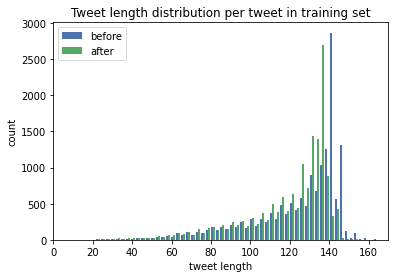

In [ ]:
plt.hist([train['length'], train['length after']], bins=100, label=['before', 'after'])
plt.title('Tweet length distribution per tweet in training set')
plt.xlabel('tweet length')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,170])
plt.show()

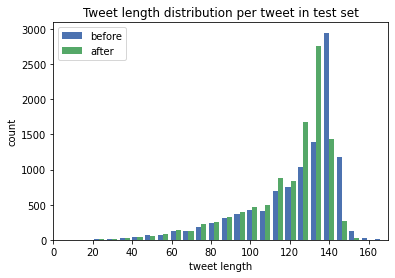

In [ ]:
plt.hist([test['length'], test['length after']], bins=100, label=['before', 'after'])
plt.title('Tweet length distribution per tweet in test set')
plt.xlabel('tweet length')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,170])
plt.show()

As we expected the tweet length distribution has been reduced. This makes sense because the preprocessinng gets rid of any unnecessary words. 

# Modelling


## Splitting the Dataset

First step is always to split the Dataset into trainig and testing sets.
This will allow us to conduct our training on the training sets and be able to test the model on the test set

In [ ]:
# Splitting the labels and fetures into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=42,stratify=y)

In [ ]:
# Creating the unseen set, so that we can post to Kaggle and recieve a score based on the performance
x_unseen = test['processed']

## Declare models

We now move on to try various models and we will then judge them with one another to see how they perform

### **Logistic regression**

In [ ]:
#creating a pipeline with a tfidf vectorizer and a logistic regression model
LR_model = Pipeline([('tfidf',TfidfVectorizer()),('classify',(LogisticRegression(C=1.0,solver='lbfgs',random_state=42,max_iter=200)))])

#fitting the model
LR_model.fit(X_train, y_train)

#Apply model on test data
y_pred_lr = LR_model.predict(X_test)

### **Linear SVC**

In [ ]:
#creating a pipeline with the tfid vectorizer and a linear svc model
svc = Pipeline([('tfidf',TfidfVectorizer()),('classify',LinearSVC(C=1))])

#fitting the model
svc.fit(X_train, y_train)

#apply model on test data
y_pred_svc = svc.predict(X_test)

### **Decision Tree**

In [ ]:
#creating a pipeline with the DecisionTreeClassifier 
DT = Pipeline([('tfidf',TfidfVectorizer()),('classify',(DecisionTreeClassifier(max_depth=150,random_state=42, splitter='best')))])

#fitting the model
DT.fit(X_train, y_train)

#Apply model on test data
y_pred_DT = DT.predict(X_test)

### **Random Forest**

In [ ]:
#creating a pipeline with the RandomForest classifier  
RF_model = Pipeline([('tfidf', TfidfVectorizer()),('clf', (RandomForestClassifier(max_depth=200, random_state=42,n_estimators=10)))])

#fitting the model
RF_model.fit(X_train, y_train)

#Apply model on test data
y_pred_RF = RF_model.predict(X_test)

### **Gradient Boosting Classifier**

In [ ]:
#creating a pipeline with the GradientBoosting classifier
gb_clf = Pipeline([('tfidf',TfidfVectorizer()),('classify',( GradientBoostingClassifier(n_estimators=20,  max_depth=150, random_state=42)))])

#fitting the model
gb_clf.fit(X_train, y_train)

#Apply model on test data
y_pred_gb = gb_clf.predict(X_test)

### **Gaussian Naive Bays** 

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
naive_bayes = pipeline = make_pipeline(
     CountVectorizer(), 
     FunctionTransformer(lambda x: x.todense(), accept_sparse=True), 
     GaussianNB())

naive_bayes.fit(X_train, y_train)

#Apply model on test data
y_pred_guassianNB = naive_bayes.predict(X_test)

### **Grid search on SVC with Linear kernel**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define component objects of our pipeline then create it!
objs = [("tfidf", TfidfVectorizer()),
        ("svm", SVC(kernel="linear"))]
pipe = Pipeline(objs)
# Specify parameters of the pipeline and their ranges for grid search
params = {'svm__C': [0.1,1,10],
          'svm__gamma': [0.01,0.1,1]}

# Construct our grid search object
search = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, verbose=1)
search.fit(X_train,y_train)
y_pred_grid = search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 19.8min finished


In [ ]:
print(search.best_params_)

{'svm__C': 1, 'svm__gamma': 0.01}


### **Upsampling**

We will try upsampling to see if we can maybe improve the model by balancing the data

In [ ]:
#creating variables for the various sentiments
pro = train[train['sentiment']==1]
news = train[train['sentiment']==2]
neutral = train[train['sentiment']==0]
anti = train[train['sentiment']==-1]

In [ ]:
# upsampling the minority
upsampled_anti = resample(anti,
                    replace=True, 
                    n_samples=len(pro), 
                    random_state=42)

upsampled_news = resample(news,
                    replace=True, 
                    n_samples=len(pro),
                    random_state=42) 

upsampled_neutral = resample(neutral,
                    replace=True, 
                    n_samples=len(pro), 
                    random_state=42) 

# Combine upsampled minority class with majority class
upsampled = pd.concat([upsampled_anti,upsampled_news, upsampled_neutral, pro])

In [ ]:
print('The distribution of samples before upsampling:')
print(train['sentiment'].value_counts())

The distribution of samples before upsampling:
 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64


In [ ]:
# Check new class counts
print('The distribution of samples after upsampling:')
print(upsampled['sentiment'].value_counts())

The distribution of samples after upsampling:
-1    8530
 2    8530
 1    8530
 0    8530
Name: sentiment, dtype: int64


We can see now the data is balanced and ready for the next steps

In [ ]:
# Splitting the labels and features into training and testing sets
upsampledX_train, upsampledX_test, upsampledy_train, upsampledy_test = train_test_split(upsampled['processed']
                                                                                        , upsampled['sentiment']
                                                                                        , test_size=0.1,random_state=42)

### **Downsampling**

We will also try downsampling as another way of trying to balance the data

In [ ]:
# Downsampling the majority
downsampled_anti = resample(pro,
                    replace=True, 
                    n_samples=len(anti), 
                    random_state=42) 

downsampled_news = resample(news,
                    replace=True, 
                    n_samples=len(anti), 
                    random_state=42) 

downsampled_neutral = resample(neutral,
                    replace=True, 
                    n_samples=len(anti),
                    random_state=42) 

# Combine downsampled majority class with minority class
downsampled = pd.concat([downsampled_anti,downsampled_news, downsampled_neutral, anti])

In [ ]:
print('The distribution of samples before upsampling:')
print(train['sentiment'].value_counts())

The distribution of samples before upsampling:
 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64


In [ ]:
# Check new class counts
print('The distribution of samples after upsampling:')
print(downsampled['sentiment'].value_counts())

The distribution of samples after upsampling:
-1    1296
 2    1296
 1    1296
 0    1296
Name: sentiment, dtype: int64


We can see once again it was succesful and the data is now balanced

In [ ]:
# Splitting the labels and features into training and testing sets
downsampledX_train, downsampledX_test, downsampledy_train, downsampledy_test = train_test_split(downsampled['processed']
                                                                                        , downsampled['sentiment']
                                                                                        , test_size=0.1,random_state=42)

### Improving Logistic Regression model with upsampling

In [ ]:
# Creating a pipeline for the new upsampled data with a LogisticRegression model
upsampled_LR = Pipeline([('tfidf', TfidfVectorizer()),
                     ('lr', LogisticRegression(solver='lbfgs', max_iter=1200000))
                      ])

# Feed the training data through the pipeline
upsampled_LR.fit(upsampledX_train, upsampledy_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [ ]:
#apply model on test data
y_pred_upsampled = upsampled_LR.predict(upsampledX_test)

### Improving Logistic regression model with downsampling

In [ ]:
# Creating another pipeline for the downsampled data with a LogisticRegression model
downsampled_LR = Pipeline([('tfidf', TfidfVectorizer()),
                     ('lr', LogisticRegression(solver='lbfgs', max_iter=1200000))
                      ])

# Feed the training data through the pipeline
downsampled_LR.fit(downsampledX_train, downsampledy_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [ ]:
#apply model on test data
y_pred_downsampled = downsampled_LR.predict(downsampledX_test)

###Improving linear SVC model with upsampling

In [ ]:
# Creating another pipeline for the upsampled data with a LinearSVC model
upsampled_svc = Pipeline([('tfidf',TfidfVectorizer()),('classify',LinearSVC())])

# Feed the training data through the pipeline
upsampled_svc.fit(upsampledX_train, upsampledy_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classify',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
          

In [ ]:
#apply model on test data
y_pred_svc_upsampled = upsampled_svc.predict(upsampledX_test)

###Improving linear SVC model with downsampling

In [ ]:
# Creating another pipeline for the downsampled data with a LinearSVC model
downsampled_svc = Pipeline([('tfidf',TfidfVectorizer()),('classify',LinearSVC())])

# Feed the training data through the pipeline
downsampled_svc.fit(downsampledX_train, downsampledy_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classify',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
          

In [ ]:
#apply model on test data
y_pred_svc_downsampled = downsampled_svc.predict(downsampledX_test)

# Model performance

Now to assess our model's performance and to see which model produces the best results, we will ust the classification report for  this

Prediction with Logistic Regression

Logistic regression is a supervised learning classification algorithm used to predict the probability of a target variable. This model works best on binary data classification but almost performs well in our data even though it badly predicts some classes such as the recall of 0 and -1. The overall accuracy is decent and it also does quite well on unseen data.

In [ ]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

          -1       0.75      0.37      0.49        65
           0       0.73      0.32      0.45       118
           1       0.72      0.89      0.80       426
           2       0.74      0.73      0.73       182

    accuracy                           0.73       791
   macro avg       0.74      0.58      0.62       791
weighted avg       0.73      0.73      0.71       791



Prediction with Linear SVC model

Linear Support Vector Machine is machine learning (data mining) algorithm for solving multiclass classification problems. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. 
We can see here that it gives a better accuracy score than the other models. 

In [ ]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

          -1       0.61      0.48      0.53        65
           0       0.66      0.42      0.51       118
           1       0.77      0.87      0.81       426
           2       0.77      0.77      0.77       182

    accuracy                           0.75       791
   macro avg       0.70      0.63      0.66       791
weighted avg       0.74      0.75      0.74       791



Prediction with Decision Tree

Decision Trees are a supervised learning technique that predict values of responses by learning decision rules derived from features. Decision tree is unstable because training a tree with a slightly different sub-sample causes the structure of the tree to change drastically. It learns from noise data as well and optimises for that particular sample, which causes its variable importance order to change significantly. This makes them inaccurate this is why our decision tree model performs badly. 

In [ ]:
print(classification_report(y_test, y_pred_DT))

              precision    recall  f1-score   support

          -1       0.36      0.28      0.31        65
           0       0.39      0.36      0.38       118
           1       0.69      0.73      0.71       426
           2       0.57      0.57      0.57       182

    accuracy                           0.60       791
   macro avg       0.50      0.48      0.49       791
weighted avg       0.59      0.60      0.60       791



Prediction with Random Forest

Random forest is a supervised learning algorithm. The "forest" it builds, is an ensemble of decision trees, usually trained with the “bagging” method. The general idea of the bagging method is that a combination of learning models increases the overall result. It performs badly because there is one feature that is out of proportion with others (1 - pro). It seems to be accurately predict pro tweets and does badly on the other features. 

In [ ]:
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

          -1       0.76      0.29      0.42        65
           0       0.62      0.36      0.46       118
           1       0.71      0.88      0.78       426
           2       0.75      0.70      0.72       182

    accuracy                           0.71       791
   macro avg       0.71      0.56      0.60       791
weighted avg       0.71      0.71      0.69       791



Prediction with Gradient Boosting

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. Boosting uses the average of the trees insted of individual trees and sometimes overfits but in our case it does not and does not perform very well.

In [ ]:
print(classification_report(y_test, y_pred_gb)) 

              precision    recall  f1-score   support

          -1       0.63      0.34      0.44        65
           0       0.51      0.31      0.38       118
           1       0.67      0.85      0.75       426
           2       0.70      0.58      0.63       182

    accuracy                           0.66       791
   macro avg       0.63      0.52      0.55       791
weighted avg       0.65      0.66      0.64       791



Prediction with Gaussian Naive Bayes

The Naïve Bayes Classifier is a classification technique based on Bayes' theorem with an assumption of independence between predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. In our data, it does not perform well at all because it has a problem of favouring one class over the others in this case class 1 (pro). The classes are uneven.

In [ ]:
print(classification_report(y_test, y_pred_guassianNB)) 

              precision    recall  f1-score   support

          -1       0.21      0.52      0.30        65
           0       0.32      0.37      0.35       118
           1       0.77      0.62      0.68       426
           2       0.64      0.53      0.58       182

    accuracy                           0.55       791
   macro avg       0.48      0.51      0.48       791
weighted avg       0.62      0.55      0.58       791



Predicting Logistic Regression with upsampling

Upsampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal. As a result of upsampling, this model performs really well but it is overfitting. There is not much variance in the 4 different classes because the observations were duplicated which means the model is biased. 

In [ ]:
print(classification_report(upsampledy_test, y_pred_upsampled))

              precision    recall  f1-score   support

          -1       0.94      0.98      0.96       854
           0       0.89      0.92      0.91       844
           1       0.89      0.73      0.80       877
           2       0.84      0.93      0.89       837

    accuracy                           0.89      3412
   macro avg       0.89      0.89      0.89      3412
weighted avg       0.89      0.89      0.89      3412



Predicting Logistic Regression with downsampling

In [ ]:
print(classification_report(downsampledy_test, y_pred_downsampled))

              precision    recall  f1-score   support

          -1       0.78      0.66      0.71       141
           0       0.65      0.58      0.61       118
           1       0.66      0.60      0.63       139
           2       0.64      0.89      0.74       121

    accuracy                           0.68       519
   macro avg       0.68      0.68      0.67       519
weighted avg       0.68      0.68      0.67       519



Predicting linear SVC with upsampling

This model has the same problem of overfitting by learning the noise in the data and as a result performs very badly on unseen data.

In [ ]:
print(classification_report(upsampledy_test, y_pred_svc_upsampled))

              precision    recall  f1-score   support

          -1       0.96      1.00      0.98       854
           0       0.93      0.97      0.95       844
           1       0.97      0.81      0.88       877
           2       0.91      0.98      0.94       837

    accuracy                           0.94      3412
   macro avg       0.94      0.94      0.94      3412
weighted avg       0.94      0.94      0.94      3412



Predicting linear SVC with downsampling

Downsampling on the other hand is keeping all the observations from the minority class and sampling without replacement is performed in the majority class where the number of observations sampled is equal to the sample size of the minority class. The model seems to be performing well and does not show signs of overfitting but from the majority class, we could be missing valuable information that could have helped our model perform even better. 

In [ ]:
print(classification_report(downsampledy_test, y_pred_svc_downsampled))

              precision    recall  f1-score   support

          -1       0.77      0.68      0.72       141
           0       0.62      0.58      0.60       118
           1       0.73      0.64      0.68       139
           2       0.68      0.90      0.77       121

    accuracy                           0.70       519
   macro avg       0.70      0.70      0.69       519
weighted avg       0.70      0.70      0.70       519



Okay so we see that at first glance our upsampled SVC and LogisticRegression far out perform the rest. unfortunately however this is due to the models overfitting the data, so it doesn't perform near as well on unseen data.

Our LinearSVC model performs the best on unseen data with a accuracy of 0.77 which is quite well, so we will use this model to submit to Kaggle.

In [ ]:
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

          -1       0.74      0.48      0.58        65
           0       0.70      0.37      0.49       118
           1       0.75      0.88      0.81       426
           2       0.76      0.76      0.76       182

    accuracy                           0.75       791
   macro avg       0.74      0.62      0.66       791
weighted avg       0.74      0.75      0.73       791



# Saving the prediction to submit on Kaggle

In [ ]:
# apply models on unseen data:

kaggle_lr = LR_model.predict(x_unseen) # Logistic Regression model
kaggle_svc = svc.predict(x_unseen) # SVC model
kaggle_DT = DT.predict(x_unseen) # Decision Tree model
kaggle_RF = RF_model.predict(x_unseen) # Random Forest model
kaggle_gb = gb_clf.predict(x_unseen) # Gradient Boosting model
kaggle_LR_upsampled = upsampled_LR.predict(x_unseen) # Logistic Regression model (upsampled)
kaggle_LR_downsampled = downsampled_LR.predict(x_unseen) # Logistic Regression model (downsampled)
kaggle_svc_upsampled = upsampled_svc.predict(x_unseen) # SVC model (upsampled)
kaggle_svc_downsampled = downsampled_svc.predict(x_unseen) # SVC model (downsampled)
kaggle_guassianNB =  naive_bayes.predict(x_unseen) # Naiave bayes model
kaggle_grid_search = search.best_estimator_.predict(x_unseen)

All in all we created 6 different models and resampled 2 of the models.
And out of all of them the SVC model held the most accurate predictions on unseen data

In [ ]:
# create table to submit as .csv file
Table = {'tweetid': test['tweetid'], 'sentiment':kaggle_svc} #choose a model e.g kaggle_svc
submission = pd.DataFrame(data=Table)
submission.set_index('tweetid')
submission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0


In [ ]:
# Only run this code if wanting to save to a CSV file
# save to .csv file
submission.to_csv("SVC.csv",index  = False)

# Comet version control

In [ ]:
# Create dictionaries for the data we want to log

params = {"preprocessing":  "_preprocess(df)",
          "keeps username":"True",
          "keeps hashtags":"True",
          "keeps URL":"urlweb",
          "removes puncutation":"string punctuation",
          "use stopwords":"False",
          "model_type": "LinearSVC",
          }


In [ ]:
# Log our parameters and results
experiment.log_parameters(params)

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/monicafar147/nlp-climate-change/9740882c0632454bb729598c89be18fb
COMET INFO:   Parameters [count]:
COMET INFO:     C                                 : 1.0
COMET INFO:     class_weight                      : 1
COMET INFO:     classify_C                        : 1.0
COMET INFO:     classify_ccp_alpha                : 1
COMET INFO:     classify_class_weight             : 1
COMET INFO:     classify_criterion [2]            : friedman_mse
COMET INFO:     classify_dual [2]                 : True
COMET INFO:     classify_fit_intercept            : True
COMET INFO:     classify_init                     : 1
COMET INFO:     classify_intercept_scaling        : 1
COMET INFO:     classify_l1_ratio                 : 1
COMET INFO:     classify_learning_rate     

In [ ]:
experiment.display()